In [1]:
# some magic to be able to import local module into jupyter notebook
# https://mg.readthedocs.io/importing-local-python-modules-from-jupyter-notebooks/index.html
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

In [2]:
from dynamite_src import gauss_hermite_kinematics as ghk
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Can we fit double peaked LOSVDs with Gauss Hermites?

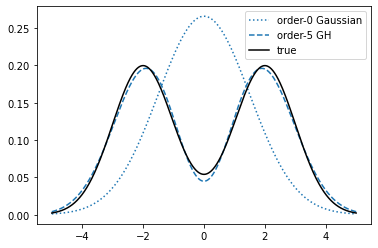

In [3]:
# setup velocity array
vedg = np.linspace(-5, 5, 1000)
v = (vedg[:-1] + vedg[1:])/2.
dv = v[1] - v[0]

# make true LOSVD
gmm = ghk.GauusianMixture1D(weights=[1,1], means=[-2,2], sigmas=[1,1])
losvd = gmm.evaluate(v)
vel_hist = ghk.Histogram(xedg=vedg, y=losvd, normalise=True)

# do GH expansion around a given v, sigma
gauherm = ghk.GaussHermite()
v_mu, v_sig, max_order = 0, 1.5, 5
h = gauherm.get_gh_expansion_coefficients(v_mu=v_mu,
                                          v_sig=v_sig,
                                          vel_hist=vel_hist,
                                          max_order=max_order)

# plot
col = 'C0'
nrm = stats.norm(v_mu, v_sig)
plt.plot(vel_hist.x, nrm.pdf(vel_hist.x),
         ':', color=col, label='order-0 Gaussian')
gh_losvd = gauherm.evaluate_losvd(vel_hist.x, v_mu, v_sig, h)
gh_losvd = np.squeeze(gh_losvd)
plt.plot(vel_hist.x, gh_losvd,
         ls='--', color=col, label=f'order-{max_order} GH')
plt.plot(vel_hist.x, vel_hist.y,
         '-k', label='true')
plt.legend()

So... can we fit double peaked LOSVD with GH? Yes, easily, if we allow $h_0, h_1, h_2$ to be free.

Gauss Hermite polynomials only seem so rigid because PPXF normally fixes them to the defaults $(h_0, h_1, h_2) = (1, 0, 0)$. Let's re-do the above fit up to $h_4$ to demonstrate.

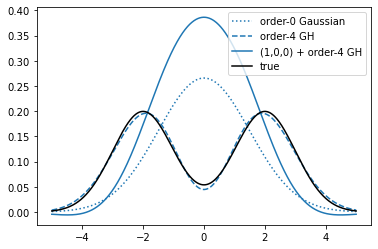

In [5]:
v_mu, v_sig, max_order = 0, 1.5, 4
h = gauherm.get_gh_expansion_coefficients(v_mu=v_mu,
                                          v_sig=v_sig,
                                          vel_hist=vel_hist,
                                          max_order=max_order)
# plot
col = 'C0'
nrm = stats.norm(v_mu, v_sig)
plt.plot(vel_hist.x, nrm.pdf(vel_hist.x),
         ':', color=col, label='order-0 Gaussian')
gh_losvd = gauherm.evaluate_losvd(vel_hist.x, v_mu, v_sig, h)
gh_losvd = np.squeeze(gh_losvd)
plt.plot(vel_hist.x, gh_losvd,
         ls='--', color=col, label=f'order-{max_order} GH')

h[:,:,0] = 1
h[:,:,1] = 0
h[:,:,2] = 0
gh_losvd = gauherm.evaluate_losvd(vel_hist.x, v_mu, v_sig, h)
gh_losvd = np.squeeze(gh_losvd)
plt.plot(vel_hist.x, gh_losvd,
         ls='-', color=col, label=f'(1,0,0) + order-{max_order} GH')
plt.plot(vel_hist.x, vel_hist.y,
         '-k', label='true')
plt.legend()

Again, the order-4 GH with all coefficients free is able to fit double peaks easily. It only struggles when we impose the $(1,0,0)$ default.

Is it possible to override the $(1,0,0)$ default in pPXF? 

The more I think about it, the odder this default is. It makes sense if you believe that the underlying LOSVD is close to the input Gaussian, but surely we want the data to tell us how close to the input Gaussian the LOSVD is, not our model. For low-quality data, over-fitting should be prevented with penalisation aka regularisation... not by truncating the first few terms of the expansion, since this severely limits the expressiveness of the model.

It seems (hopefully...) unlikely that the $(h_0, h_1, h_2) = (1, 0, 0)$ default could be fixed so hard in pPXF that it cannot be chnaged. Maybe it can!